# Import Library

In [3]:
import os
import nibabel as nib
import numpy as np
from scipy import ndimage
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.ndimage

# HyperParameter

In [23]:
DEVICE = None
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Using CUDA!")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU!")
EPOCHS = 25
TRAIN_SPLIT = 0.8
LR = 1e-2
STEP_SIZE = 5
GAMMA = 0.1
MANUAL_SEED = 42
BATCH_SIZE = 1
CLASS = 5
TARGET_SIZE = 32

Using CPU!


In [24]:
import torch
import numpy as np
import random

def set_random_seed(seed):
    """
    모든 관련 라이브러리의 랜덤 시드를 고정합니다.
    
    Args:
        seed (int): 고정할 랜덤 시드 값
    """
    # Python 내장 랜덤 시드 고정
    random.seed(seed)
    
    # NumPy 랜덤 시드 고정
    np.random.seed(seed)
    
    # PyTorch 랜덤 시드 고정
    torch.manual_seed(seed)  # CPU에서 PyTorch 랜덤 시드 고정
    torch.cuda.manual_seed(seed)  # GPU에서 PyTorch 랜덤 시드 고정 (CUDA 장치)
    torch.cuda.manual_seed_all(seed)  # 모든 GPU에서 PyTorch 랜덤 시드 고정
    
    # CuDNN 관련 설정
    torch.backends.cudnn.deterministic = True  # 결정적 알고리즘을 사용하여 결과 고정
    torch.backends.cudnn.benchmark = False  # 벤치마크 모드를 비활성화하여 성능 최적화 방지

# 시드 고정 예시
set_random_seed(MANUAL_SEED)

# Data Preprocessing

In [25]:
def read_nifti_file(filepath):
    """Read and load volume"""
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """Normalize the volume"""
    min_val = -1000
    max_val = 400
    volume[volume < min_val] = min_val
    volume[volume > max_val] = max_val
    volume = (volume - min_val) / (max_val - min_val)
    volume = volume.astype("float32")
    return volume

# interpolation?
def resize(image, target_size):
    """이미지 크기 조정 (PIL 없이 numpy 기반)"""
    print(image.ndim)
    # 이미지가 2D일 경우 (H, W)로 크기 조정
    if image.ndim == 2:
        return scipy.ndimage.zoom(image, (target_size[0] / image.shape[0], target_size[1] / image.shape[1]), order=1)
    # 이미지가 3D일 경우 (H, W, C)로 크기 조정
    elif image.ndim == 3:
        return np.concatenate([scipy.ndimage.zoom(image[..., i], (target_size[0] / image.shape[0], target_size[1] / image.shape[1]), order=1)[:, :, np.newaxis] for i in range(image.shape[2])], axis=-1)
    else:
        raise ValueError("Unsupported image dimensions")
            
def resize_volume(img):
    """Resize to 64x64x64"""
    desired_depth = TARGET_SIZE
    desired_width = TARGET_SIZE
    desired_height = TARGET_SIZE
    
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    
    depth_factor = desired_depth / current_depth
    width_factor = desired_width / current_width
    height_factor = desired_height / current_height
    
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [26]:
# import os

# # 경로 설정 (현재 작업 디렉토리 기준)
# data_dir = './dataset/label'

# # 숫자 001부터 369까지 파일이 있는지 확인 (_001, _002, ...)
# expected_files = [f"label_{str(i).zfill(3)}.nii" for i in range(1, 370)]

# # 실제 파일 목록 가져오기
# try:
#     actual_files = sorted(os.listdir(data_dir))
#     # 실제 파일 목록에 있는지 확인
#     missing_files = [file for file in expected_files if file not in actual_files]

#     if missing_files:
#         print("Missing files:", missing_files)
#     else:
#         print("All expected files are present.")
# except FileNotFoundError:
#     print(f"The directory {data_dir} does not exist.")


# Dataset

In [27]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

class BraTSDataset(Dataset):
    def __init__(self, data_dir, label_dir):
        self.data_paths = sorted([f for f in os.listdir(data_dir) if f.endswith('.nii')])
        self.label_paths = sorted([f for f in os.listdir(label_dir) if f.endswith('.nii')])
        self.data_dir = data_dir
        self.label_dir = label_dir

        # 데이터와 라벨의 개수가 일치하는지 확인
        assert len(self.data_paths) == len(self.label_paths), \
            f"Mismatch between data and label files: {len(self.data_paths)} | {len(self.label_paths)}"
    
    def __len__(self):
        return len(self.data_paths)
    
    def __getitem__(self, idx):
        data_path = os.path.join(self.data_dir, self.data_paths[idx])
        label_path = os.path.join(self.label_dir, self.label_paths[idx])
        
        data = read_nifti_file(data_path)
        label = read_nifti_file(label_path)

        # 최소, 최대 값 계산
        # min_val = np.min(data)
        # max_val = np.max(data)
        # print(min_val, max_val)
        data = normalize(data)
        data = resize_volume(data)
        label = resize_volume(label)

        # Convert numpy to torch tensor
        data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)     # Add channel dimension
        label = torch.tensor(label, dtype=torch.long)                   # For segmentation tasks, long type is needed for one-hot encoding

        # One-hot encoding: (64, 64, 64) -> (64, 64, 64, 5) -> (5, 64, 64, 64)
        label_one_hot = F.one_hot(label, num_classes=5).permute(3, 0, 1, 2).float()

        return data, label_one_hot


In [28]:
dataset = BraTSDataset("./dataset/data", "./dataset/label")
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

data shape:  torch.Size([1, 32, 32, 32]) <class 'torch.Tensor'>
label shape:  torch.Size([5, 32, 32, 32]) <class 'torch.Tensor'>
(32, 32, 32)
torch.Size([32, 32, 32])


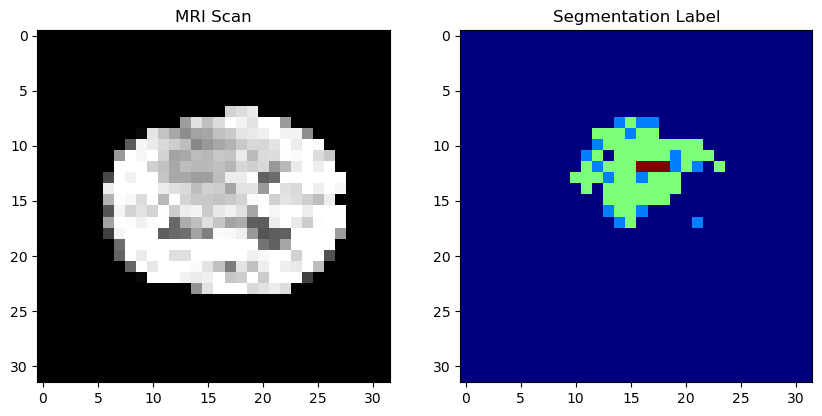

In [29]:
def visualize_sample(dataset, idx=0):
    """Visualize a single sample from the dataset"""
    data, label = dataset[idx]
    print("data shape: ", data.shape, type(data))
    print("label shape: ", label.shape, type(label))
    
    data = data.squeeze().numpy()
    label = torch.argmax(label, dim=0)
    
    print(data.shape)
    print(label.shape)
    slice_idx = data.shape[-1] // 2  # Select middle slice
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(data[:, :, slice_idx], cmap='gray')
    axes[0].set_title("MRI Scan")
    
    axes[1].imshow(label[:, :, slice_idx], cmap='jet')
    axes[1].set_title("Segmentation Label")
    
    plt.show()

visualize_sample(dataset, idx=0)

# Model

In [30]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class SingleDeconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose3d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)


class SingleConv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)


class Conv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv3DBlock(in_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class Deconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv3DBlock(in_planes, out_planes),
            SingleConv3DBlock(out_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class SelfAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, dropout):
        super().__init__()
        self.num_attention_heads = num_heads
        self.attention_head_size = int(embed_dim / num_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(embed_dim, self.all_head_size)
        self.key = nn.Linear(embed_dim, self.all_head_size)
        self.value = nn.Linear(embed_dim, self.all_head_size)

        self.out = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

        self.softmax = nn.Softmax(dim=-1)

        self.vis = False

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights


class Mlp(nn.Module):
    def __init__(self, in_features, act_layer=nn.GELU, drop=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, in_features)
        self.act = act_layer()
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1()
        x = self.act(x)
        x = self.drop(x)
        return x


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model=786, d_ff=2048, dropout=0.1):
        super().__init__()
        # Torch linears have a `b` by default.
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class Embeddings(nn.Module):
    def __init__(self, input_dim, embed_dim, cube_size, patch_size, dropout):
        super().__init__()
        self.n_patches = int((cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_embeddings = nn.Conv3d(in_channels=input_dim, out_channels=embed_dim,
                                          kernel_size=patch_size, stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.n_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.patch_embeddings(x)
        x = x.flatten(2)
        x = x.transpose(-1, -2)
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings


class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, cube_size, patch_size):
        super().__init__()
        self.attention_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_dim = int((cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
        self.mlp = PositionwiseFeedForward(embed_dim, 2048)
        self.attn = SelfAttention(num_heads, embed_dim, dropout)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h
        h = x

        x = self.mlp_norm(x)
        x = self.mlp(x)

        x = x + h
        return x, weights


class Transformer(nn.Module):
    def __init__(self, input_dim, embed_dim, cube_size, patch_size, num_heads, num_layers, dropout, extract_layers):
        super().__init__()
        self.embeddings = Embeddings(input_dim, embed_dim, cube_size, patch_size, dropout)
        self.layer = nn.ModuleList()
        self.encoder_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.extract_layers = extract_layers
        for _ in range(num_layers):
            layer = TransformerBlock(embed_dim, num_heads, dropout, cube_size, patch_size)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, x):
        extract_layers = []
        hidden_states = self.embeddings(x)

        for depth, layer_block in enumerate(self.layer):
            hidden_states, _ = layer_block(hidden_states)
            if depth + 1 in self.extract_layers:
                extract_layers.append(hidden_states)

        return extract_layers


class UNETR(nn.Module):
    def __init__(self, img_shape=(128, 128, 128), input_dim=4, output_dim=3, embed_dim=768, patch_size=16, num_heads=12, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = 12
        self.ext_layers = [3, 6, 9, 12]

        self.patch_dim = [int(x / patch_size) for x in img_shape]

        # Transformer Encoder
        self.transformer = \
            Transformer(
                input_dim,
                embed_dim,
                img_shape,
                patch_size,
                num_heads,
                self.num_layers,
                dropout,
                self.ext_layers
            )

        # U-Net Decoder
        self.decoder0 = \
            nn.Sequential(
                Conv3DBlock(input_dim, 32, 3),
                Conv3DBlock(32, 64, 3)
            )

        self.decoder3 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, 512),
                Deconv3DBlock(512, 256),
                Deconv3DBlock(256, 128)
            )

        self.decoder6 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, 512),
                Deconv3DBlock(512, 256),
            )

        self.decoder9 = \
            Deconv3DBlock(embed_dim, 512)

        self.decoder12_upsampler = \
            SingleDeconv3DBlock(embed_dim, 512)

        self.decoder9_upsampler = \
            nn.Sequential(
                Conv3DBlock(1024, 512),
                Conv3DBlock(512, 512),
                Conv3DBlock(512, 512),
                SingleDeconv3DBlock(512, 256)
            )

        self.decoder6_upsampler = \
            nn.Sequential(
                Conv3DBlock(512, 256),
                Conv3DBlock(256, 256),
                SingleDeconv3DBlock(256, 128)
            )

        self.decoder3_upsampler = \
            nn.Sequential(
                Conv3DBlock(256, 128),
                Conv3DBlock(128, 128),
                SingleDeconv3DBlock(128, 64)
            )

        self.decoder0_header = \
            nn.Sequential(
                Conv3DBlock(128, 64),
                Conv3DBlock(64, 64),
                SingleConv3DBlock(64, output_dim, 1)
            )

    def forward(self, x):
        z = self.transformer(x)
        z0, z3, z6, z9, z12 = x, *z
        z3 = z3.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z6 = z6.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z9 = z9.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z12 = z12.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)

        z12 = self.decoder12_upsampler(z12)
        z9 = self.decoder9(z9)
        z9 = self.decoder9_upsampler(torch.cat([z9, z12], dim=1))
        z6 = self.decoder6(z6)
        z6 = self.decoder6_upsampler(torch.cat([z6, z9], dim=1))
        z3 = self.decoder3(z3)
        z3 = self.decoder3_upsampler(torch.cat([z3, z6], dim=1))
        z0 = self.decoder0(z0)
        output = self.decoder0_header(torch.cat([z0, z3], dim=1))
        return output

In [31]:
model = UNETR(img_shape=(32,32,32),input_dim=1, output_dim=5)
x = torch.randn(1, 1, 32, 32, 32)  # Example 3D volume
output = model(x)
print(output.shape)

torch.Size([1, 5, 32, 32, 32])


# Class Weight

In [13]:
from collections import Counter
import numpy as np

# 데이터셋에서 클래스별 샘플 개수 계산
labels = []  # 전체 데이터셋에서 라벨을 수집해야 함
for _, label in train_loader:
    label = torch.argmax(label, dim=1)  # 원-핫 벡터를 클래스 인덱스로 변환
    labels.extend(label.cpu().numpy().flatten())  # numpy 배열로 변환 후 리스트에 추가

# 클래스별 샘플 개수 계산
class_counts = Counter(labels)
total_samples = sum(class_counts.values())

# 가중치 계산: 총 샘플 수 / (클래스별 샘플 수 * 클래스 개수)
class_weights = {cls: total_samples / (count * len(class_counts)) for cls, count in class_counts.items()}
class_weights = torch.tensor(list(class_weights.values()), dtype=torch.float).to(DEVICE)

print("Class Weights:", class_weights)

Class Weights: tensor([2.0204e-01, 4.6540e+01, 2.7435e+02, 1.7721e+02, 5.1014e+01])


# Train

In [32]:
model.to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)  # Reduce LR by 0.1 every 5 epochs

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for data, label in progress_bar:
        # extract data and label
        data, label = data.to(DEVICE), label.to(DEVICE)

        # reset optimizer
        optimizer.zero_grad()

        # model output
        output = model(data)

        # change label shape to 1 x D x D x D 
        label = torch.argmax(label, dim=1, keepdim=True).squeeze(1)

        loss = criterion(output, label)
        loss.backward()
    
        optimizer.step()

        epoch_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())
    
    # save model
    torch.save(model.state_dict(), f'./model/3DUNet_{epoch+1}.pth')
    print(f"Epoch {epoch+1} Loss: {epoch_loss/len(train_loader):.4f}")

    # learning rate scheduler step
    scheduler.step()


Epoch 1/25:   1%|          | 2/294 [00:08<19:34,  4.02s/it, loss=2.54]


KeyboardInterrupt: 

In [ ]:
# # Load Model
# model = UNet3D(in_channels=1, out_channels=5)

# from torchinfo import summary
# summary(model, input_size=(1,1,32,32,32))

# state_dict = torch.load("./model/3DUNet_20.pth", map_location=torch.device(DEVICE))     # state_dict 저장

# model.load_state_dict(state_dict=state_dict)  

/var/folders/nl/8f5dczz52v56d7f3qlhdknp40000gn/T/ipykernel_3940/847289548.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("./model/3DUNet_20.pth"

<All keys matched successfully>

# Test

In [48]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import sys
import torch
import torch.nn.functional as F

import nibabel as nib

def save_as_nifti(tensor, filename):
    """
    Save a tensor as a NIfTI file.
    tensor: Tensor to be saved as NIfTI.
    filename: The output file name.
    """
    # 텐서를 numpy 배열로 변환 (NIfTI는 numpy 배열을 요구)
    
    # NIfTI 이미지로 변환 (Voxel 크기 정보가 필요할 경우, 적절히 설정할 수 있습니다)
    nifti_img = nib.Nifti1Image(tensor, affine=np.eye(4))  # affine는 단위 행렬로 설정 (원하는 좌표계로 수정 가능)
    
    # NIfTI 파일로 저장
    nib.save(nifti_img, filename)

# def save_as_nifti_labelmap(tensor, filename):
#     if isinstance(tensor, torch.Tensor):
#         tensor = tensor.cpu().numpy()
#     tensor = tensor.astype(np.uint8)
    
#     # 새로운 NIfTI 헤더 생성
#     hdr = nib.Nifti1Header()
#     hdr.set_data_dtype(np.uint8)
    
#     # 'label' intent를 설정하면 intent_code가 1002 (NIFTI_INTENT_LABEL)로 설정됩니다.
#     hdr.set_intent('label', (), 'label')
#     hdr['intent_name'] = b'LabelMap'
#     hdr['descrip'] = b'LabelMap volume'
    
#     # 계산 값 최소/최대 (선택 사항)
#     hdr['cal_min'] = 0
#     hdr['cal_max'] = int(tensor.max())
    
#     # qform, sform 코드 설정 (기본 affine 정보를 의미)
#     hdr['qform_code'] = 1
#     hdr['sform_code'] = 1
    
#     # NIfTI 이미지 생성 (affine은 단위 행렬, 필요시 수정)
#     nifti_img = nib.Nifti1Image(tensor, affine=np.eye(4), header=hdr)
#     nib.save(nifti_img, filename)
    

def multiclass_dice_coeff(input, target, epsilon=1e-6):
    """
    Compute the Dice Score for multi-class segmentation.
    
    Args:
        input (torch.Tensor): Model output logits (C, H, W, D).
        target (torch.Tensor): Ground truth labels (C, H, W, D).
        epsilon (float): Small value to avoid division by zero.
        
    Returns:
        mean_dice (float): Mean Dice Score across all classes.
    """
    input = torch.argmax(input, dim=0)  # (H, W, D) - get class index with highest logit
    
    # Ensure target is long type and convert to one-hot
    target = target.int()
    # target_one_hot = F.one_hot(target.argmax(dim=1), num_classes=num_classes).permute(3, 0, 1, 2).float()  # (C, H, W, D)
    
    # Calculate intersection and union
    intersection = (input * target).sum()  # (C)
    union = input.sum() + target.sum()  # (C)

    # Compute Dice score per class
    dice_per_class = (2. * intersection + epsilon) / (union + epsilon)  # (C)

    # Compute mean Dice score across all classes
    mean_dice = dice_per_class.mean()  # Scalar

    return mean_dice



# Test loop
save = False
total_dice = 0
total_samples = 0

model.to(DEVICE)
model.eval()
total_loss = 0
criterion = nn.CrossEntropyLoss(weight=class_weights)

with torch.no_grad():
    for batch_idx, (data, label) in tqdm(enumerate(test_loader), desc="Testing"):
        data, label = data.to(DEVICE), label.to(DEVICE)
        
        data_clone = data.clone()

        label_clone = label.clone()

        # change label shape to 1 x D x D x D 
        label_clone = torch.argmax(label_clone, dim=1, keepdim=True).squeeze(1)

        output = model(data)  # Output shape: (batch, C, H, W, D)

        # Compute loss
        loss = criterion(output, label_clone)  # CrossEntropyLoss expects (batch, C, H, W, D) and (batch, H, W, D)
        total_loss += loss.item()

        # Save predictions and labels as NIfTI files
        for i in range(data.size(0)):  # Loop over batch

            # dice score
            dice = multiclass_dice_coeff(output[i], label[i]) #  C x D x D x D | C x D X D x D로 들어옴
            print(dice.item())
            total_dice += dice.item()
            total_samples += 1

            original_filename = f"original_{batch_idx}_{i}.nii"
            pred_filename = f"pred_{batch_idx}_{i}.nii"
            label_filename = f"label_{batch_idx}_{i}.nii"

            # Input: directly using logits, no need for softmax
            pred = torch.argmax(output[i], dim=0)  # (H, W, D) - get class index with highest logit
            original = torch.argmax(data_clone[i], dim=0)
            # Label: Convert ground truth to class index
            gt_label = torch.argmax(label[i], dim=0)

            # check
            # unique_elements, counts = torch.unique(gt_label, return_counts=True)
            # print(unique_elements)
            # print(counts)
            # print(counts.sum())
            # unique_elements, counts = torch.unique(pred, return_counts=True)
            # print(unique_elements)
            # print(counts)
            # print(counts.sum())
            
            # print(pred.cpu().numpy().astype(np.int16))
            
            if save == False:
                unique_elements, counts = torch.unique(pred, return_counts=True)
                print(unique_elements)
                print(counts)
                print(counts.sum())
                unique_elements, counts = torch.unique(gt_label, return_counts=True)
                print(unique_elements)
                print(counts)
                print(counts.sum())
                print(original.shape)
                print(pred.shape)
                print(gt_label.shape)
                torch.set_printoptions(threshold=sys.maxsize)

                # Save as NIfTI 
                save_as_nifti(original.cpu().numpy().astype(np.int16), original_filename)
                save_as_nifti(pred.cpu().numpy().astype(np.int16), pred_filename)
                save_as_nifti(gt_label.cpu().numpy().astype(np.int16), label_filename)

                save = True
        
# Compute average Dice Accuracy
avg_dice = total_dice / total_samples
avg_loss = total_loss / total_samples

print(f"Test Dice Accuracy: {avg_dice:.4f}")
print(f"Average Test Loss: {avg_loss:.4f}")


Testing: 0it [00:00, ?it/s]

Testing: 1it [00:00,  1.89it/s]

0.4500260055065155
tensor([0, 2, 3, 4])
tensor([29570,  1534,   210,  1454])
tensor(32768)
tensor([0, 1, 2, 3, 4])
tensor([32475,   109,   135,    35,    14])
tensor(32768)
torch.Size([32, 32, 32])
torch.Size([32, 32, 32])
torch.Size([32, 32, 32])
0.5124387145042419


Testing: 2it [00:01,  1.83it/s]

0.430801659822464
0.47349298000335693


Testing: 3it [00:01,  1.87it/s]

0.49966806173324585
0.5094953179359436


Testing: 4it [00:02,  1.87it/s]

0.3880758583545685
0.44439697265625


Testing: 5it [00:02,  1.85it/s]

0.42423659563064575
0.4808882474899292


Testing: 6it [00:03,  1.90it/s]

0.46087366342544556
0.4926976263523102


Testing: 7it [00:03,  1.97it/s]

0.5002860426902771
0.5105454325675964


Testing: 8it [00:04,  1.99it/s]

0.3986707627773285
0.4498426914215088


Testing: 9it [00:04,  1.95it/s]

0.4604759216308594
0.5150677561759949


Testing: 10it [00:05,  1.94it/s]

0.4822251498699188
0.4156654179096222


Testing: 11it [00:05,  1.92it/s]

0.4962599277496338
0.48092347383499146


Testing: 12it [00:06,  1.89it/s]

0.5142598152160645
0.4924202263355255


Testing: 13it [00:06,  1.89it/s]

0.4929055869579315
0.4325281083583832


Testing: 14it [00:07,  1.92it/s]

0.4771465063095093
0.43641743063926697


Testing: 15it [00:07,  1.98it/s]

0.48720020055770874
0.5012121200561523


Testing: 16it [00:08,  1.98it/s]

0.5146638751029968
0.4524051249027252


Testing: 17it [00:08,  2.03it/s]

0.47806599736213684
0.5219999551773071


Testing: 18it [00:09,  2.02it/s]

0.49770769476890564
0.47391951084136963


Testing: 19it [00:09,  2.06it/s]

0.5058593153953552
0.44439697265625


Testing: 20it [00:10,  2.03it/s]

0.47256794571876526
0.4826468527317047


Testing: 21it [00:10,  2.07it/s]

0.44907233119010925
0.4618128836154938


Testing: 22it [00:11,  2.03it/s]

0.40665191411972046
0.49594932794570923


Testing: 23it [00:11,  1.99it/s]

0.44147443771362305
0.5195626616477966


Testing: 24it [00:12,  1.93it/s]

0.3909253776073456
0.4358203113079071


Testing: 25it [00:12,  1.91it/s]

0.4792667329311371
0.4204767346382141


Testing: 26it [00:13,  1.94it/s]

0.4777478277683258
0.43249061703681946


Testing: 27it [00:13,  1.89it/s]

0.49918702244758606
0.38485804200172424


Testing: 28it [00:14,  1.88it/s]

0.45685088634490967
0.5205986499786377


Testing: 29it [00:14,  1.88it/s]

0.4812754988670349
0.524595320224762


Testing: 30it [00:15,  1.83it/s]

0.5055185556411743
0.49217742681503296


Testing: 31it [00:16,  1.87it/s]

0.45156413316726685
0.4947056472301483


Testing: 32it [00:16,  1.87it/s]

0.508104145526886
0.4193338453769684


Testing: 33it [00:17,  1.95it/s]

0.47894906997680664
0.5112221837043762


Testing: 34it [00:17,  1.99it/s]

0.4137096405029297
0.4182274639606476


Testing: 35it [00:18,  1.95it/s]

0.45775875449180603
0.49252426624298096


Testing: 36it [00:18,  1.93it/s]

0.4253345727920532
0.4526609182357788


Testing: 37it [00:19,  1.93it/s]

0.4879680573940277
0.4101693332195282
Test Dice Accuracy: 0.4683
Average Test Loss: 73.5503


In [ ]:
class MeanIoU:
    """
    Computes IoU for each class separately and then averages over all classes.

    Args:
        skip_background (bool): if True, background class (i.e. 0-label) will be skipped when computing IoU
    """

    def __init__(self, skip_background=True, **kwargs):
        self.skip_background = skip_background

    def __call__(self, input, target):
        """
        :param input: 5D probability maps torch float tensor (NxCxDxHxW)
        :param target: 4D or 5D ground truth torch tensor. 4D (NxDxHxW) tensor will be expanded to 5D as one-hot
        :return: intersection over union averaged over all channels
        """
        input_softmax = torch.softmax(input, dim=1)  # (2, 5, 64, 64, 64)

        assert input.dim() == 5

        n_classes = input.size(1)

        if target.dim() == 4:
            # convert input to segmentation
            input = input.argmax(dim=1)

        assert input.size() == target.size()

        per_batch_iou = []
        for _input, _target in zip(input, target):
            # convert target to byte
            _target = _target.byte()
            per_channel_iou = []
            start_idx = 0
            # skip background only if target is 4D; for channel-wise computation (i.e. if target is 5D) we need to include it
            if self.skip_background and target.dim() == 4:
                start_idx = 1

            for c in range(start_idx, n_classes):
                if target.dim() == 5:
                    iou = self._jaccard_index(_input[c] > 0.4, _target[c])
                    per_channel_iou.append(iou)
                else:
                    iou = self._jaccard_index(_input == c, _target == c)
                    per_channel_iou.append(iou)

            assert per_channel_iou, "All channels were ignored from the computation"
            mean_iou = torch.tensor(per_channel_iou).mean()
            per_batch_iou.append(mean_iou)

        return torch.tensor(per_batch_iou).mean()

    def _jaccard_index(self, prediction, target):
        """
        Computes IoU for a given target and prediction tensors
        """
        epsilon = 1e-8
        intersection = torch.logical_and(target, prediction).sum()
        union = torch.logical_or(target, prediction).sum()
        return (intersection + epsilon) / (union + epsilon)

In [22]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from tqdm import tqdm

import torch
import torch.nn.functional as F

total_dice = 0
total_samples = 0

model.to(DEVICE)
model.eval()
total_loss = 0
criterion = nn.CrossEntropyLoss(weight=class_weights)

with torch.no_grad():
    for batch_idx, (data, label) in tqdm(enumerate(test_loader), desc="Testing"):
        data, label = data.to(DEVICE), label.to(DEVICE)
        data = torch.softmax(data, dim=1)  # (2, 5, 64, 64, 64)

        # print(data.shape)
        # print(label.shape)

        output = model(data)  # Output shape: (batch, C, H, W, D)
        
        # IoU 계산
        metric = MeanIoU(skip_background=True)
        iou = metric(output, label)  # target을 byte로 변환
        print(iou)
        # Compute loss
        loss = criterion(output, label_clone)  # CrossEntropyLoss expects (batch, C, H, W, D) and (batch, H, W, D)
        total_loss += loss.item()

        # update accuracy
        total_dice += iou
        total_samples += 1
        
# Compute average Dice Accuracy
avg_dice = total_dice / total_samples
avg_loss = total_loss / total_samples

print(f"Test Dice Accuracy: {avg_dice:.4f}")
print(f"Average Test Loss: {avg_loss:.4f}")


Testing: 1it [00:00,  1.56it/s]

tensor(0.0385)


Testing: 2it [00:01,  1.61it/s]

tensor(0.0370)


Testing: 3it [00:01,  1.65it/s]

tensor(0.0382)


Testing: 4it [00:02,  1.65it/s]

tensor(0.0375)


Testing: 5it [00:03,  1.68it/s]

tensor(0.0373)


Testing: 6it [00:03,  1.57it/s]

tensor(0.0378)


KeyboardInterrupt: 